Example notebook showing how to use the MCMC sampler (currently in development)

In [1]:
import os
import sys
import argparse
import torch
from getdist import plots, MCSamples
import getdist
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import emcee

In [2]:
path = os.path.realpath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, path)

In [3]:
from nnest import MCMCSampler
from nnest.likelihoods import *

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# Likelihood
#like = Himmelblau(2)
#like = Rosenbrock(2)
#like = Gaussian(2, 0.9)
#like = Eggbox(2)
like = GaussianShell(2)
prior = lambda x: -np.inf if np.any(np.abs(x) > 5) else 0
#like = GaussianMix(2)

In [6]:
sampler = MCMCSampler(like.x_dim, like.loglike, hidden_dim=16, num_blocks=3, flow='spline', prior=prior)

Creating directory for new run logs/test/run134
[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_f

In [7]:
nwalkers = 10
init_scale = 10.0
steps = 1000
init = init_scale * (np.random.rand(nwalkers, like.x_dim) - 0.5)
emcee_sampler = emcee.EnsembleSampler(
    nwalkers,
    like.x_dim,
    like.loglike,
    moves=[
        (emcee.moves.DEMove(), 0.5),
        (emcee.moves.DESnookerMove(), 0.3),
        (emcee.moves.KDEMove(), 0.2),
    ]
)
emcee_sampler.run_mcmc(init, steps)
try:
    print(emcee_sampler.get_autocorr_time())
except:
    print('Autocorrelation exceeds chain length')
print('Mean acceptance fraction: [%5.3f]' % np.mean(emcee_sampler.acceptance_fraction))
init_samples = emcee_sampler.get_chain(flat=True, thin=1, discard=100)

Autocorrelation exceeds chain length
Mean acceptance fraction: [0.080]


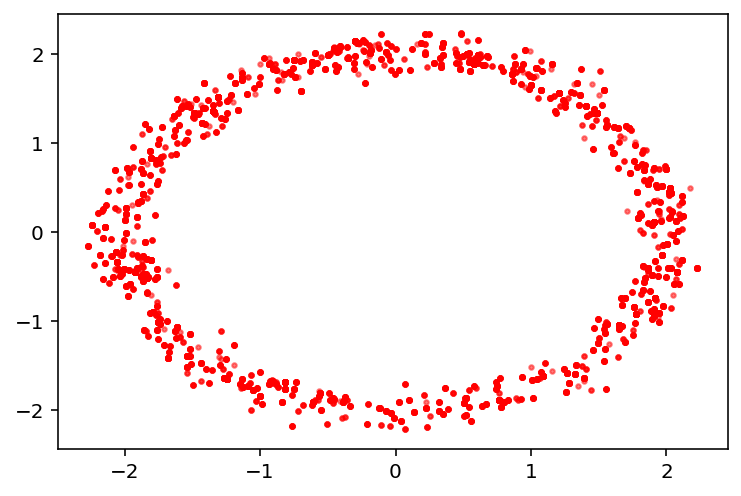

In [8]:
if like.x_dim == 2:
    plt.scatter(init_samples[:, 0], init_samples[:, 1], c='r', s=5, alpha=0.5)
    plt.show()

In [9]:
init_samples = sampler._init_samples(init_scale=5, propose_scale=1.0, temperature=10.0)

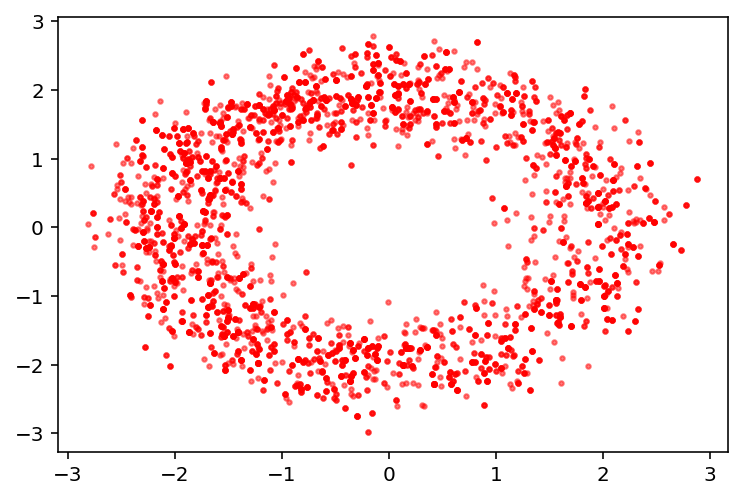

In [10]:
if like.x_dim == 2:
    plt.scatter(init_samples[:, 0], init_samples[:, 1], c='r', s=5, alpha=0.5)
    plt.show()

In [11]:
sampler.run(jitter=0.01, init_samples=init_samples)

[nnest.sampler] [INFO] Alpha [0.7071]
[nnest.trainer] [INFO] Number of training samples [1000]
[nnest.trainer] [INFO] Training jitter [0.0100]
[nnest.trainer] [INFO] Epoch [1] train loss [0.0290] validation loss [0.0283]
[nnest.trainer] [INFO] Epoch [50] train loss [0.0225] validation loss [0.0225]
[nnest.trainer] [INFO] Best epoch [50] validation loss [0.0225]
[nnest.sampler] [INFO] Bootstrap step [1], ncalls [0] 
[nnest.sampler] [INFO] MCMC step [100], ncalls [409] 
[nnest.sampler] [INFO] Acceptance [0.2440] min ESS [4.8917] max ESS [7.6537] average jump distance [0.1867]
[nnest.sampler] [INFO] Bootstrap step [2], ncalls [409] 
[nnest.sampler] [INFO] MCMC step [100], ncalls [414] 
[nnest.sampler] [INFO] Acceptance [0.2600] min ESS [7.4403] max ESS [7.6954] average jump distance [0.2121]
[nnest.sampler] [INFO] Bootstrap step [3], ncalls [823] 
[nnest.sampler] [INFO] MCMC step [100], ncalls [410] 
[nnest.sampler] [INFO] Acceptance [0.2420] min ESS [4.0277] max ESS [4.9823] average jump

In [12]:
samples = [sampler.samples[i, :, :].squeeze() for i in range(sampler.samples.shape[0])]
latent_samples = [sampler.latent_samples[i, :, :].squeeze() for i in range(sampler.latent_samples.shape[0])]
loglikes = [sampler.loglikes[i, :].squeeze() for i in range(sampler.loglikes.shape[0])]

In [13]:
mc = MCSamples(samples=samples, loglikes=loglikes)

Removed no burn in


In [14]:
print(mc.getEffectiveSamples())
print(mc.getMargeStats())
print(mc.getConvergeTests())

1144.5205411777858
Marginalized limits: 0.68; 0.95; 0.99

parameter   mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
param1     -5.6089509E-02  1.4348407E+00 -2.1288201E+00  2.0996847E+00  two   -2.0747605E+00  2.0460975E+00  two   -2.1655520E+00  2.1461814E+00  two     p_{1}
param2     -6.9324575E-02  1.4223561E+00 -2.1173880E+00  2.0931909E+00  two   -2.0700285E+00  2.0450277E+00  two   -2.1633493E+00  2.1565557E+00  two     p_{2}

Parameter autocorrelation lengths (effective number of samples N_eff = tot weight/weight length)

            Weight Length   Sample length           N_eff
param1           2.17E+01           21.71            1152
param2           2.20E+01           22.03            1135


mean convergence stats using remaining chains
param sqrt(var(chain mean)/mean(chain var))

param1        0.0375  p_{1}
param2        0.0777  p_{2}

var(mean)/mean(var) for eigenvalues of covari

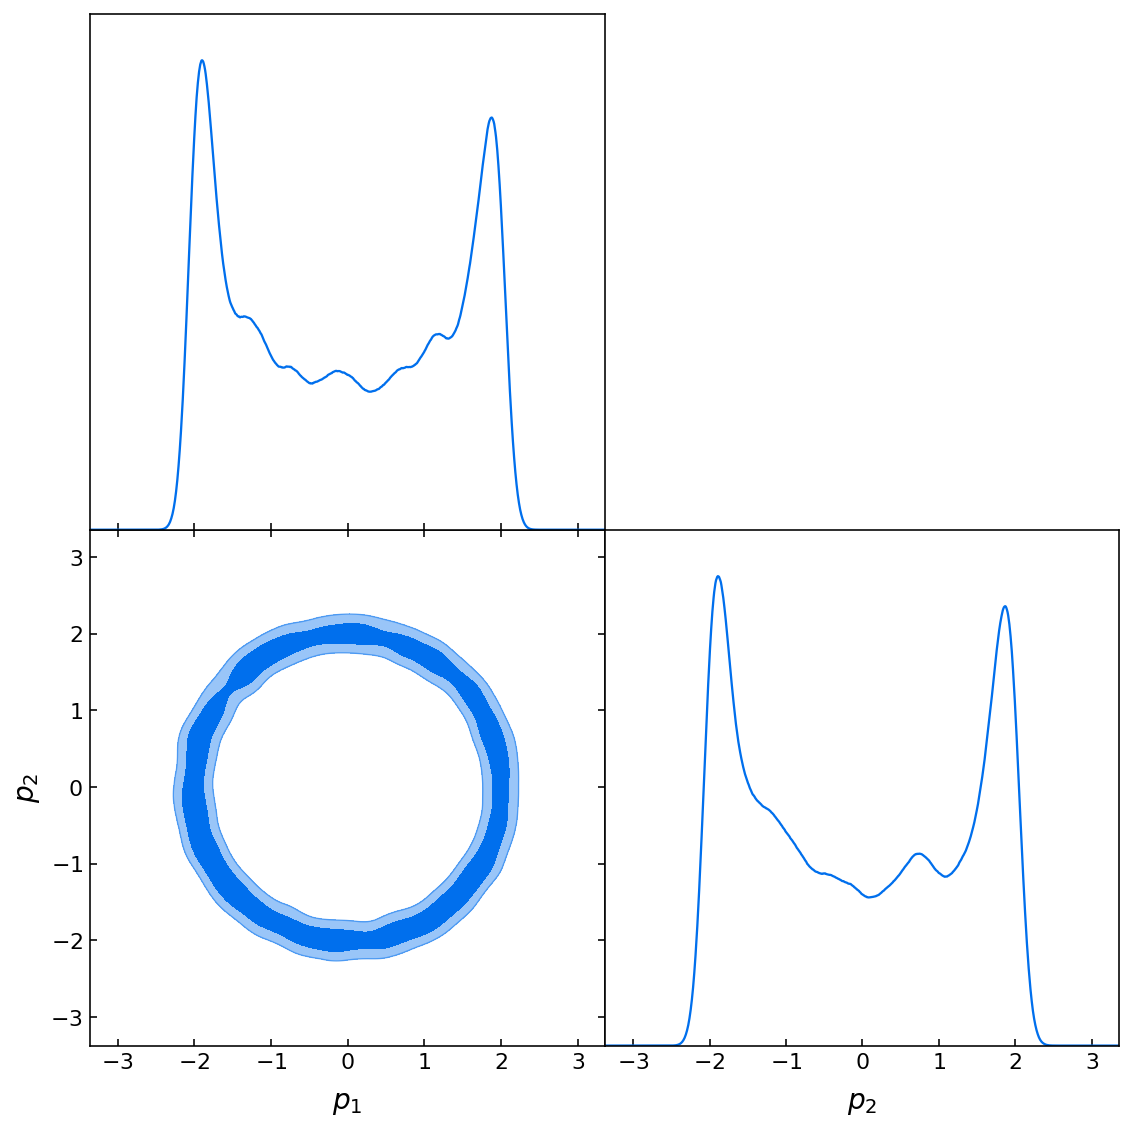

In [15]:
g = plots.getSubplotPlotter(width_inch=8)
g.triangle_plot(mc, filled=True)

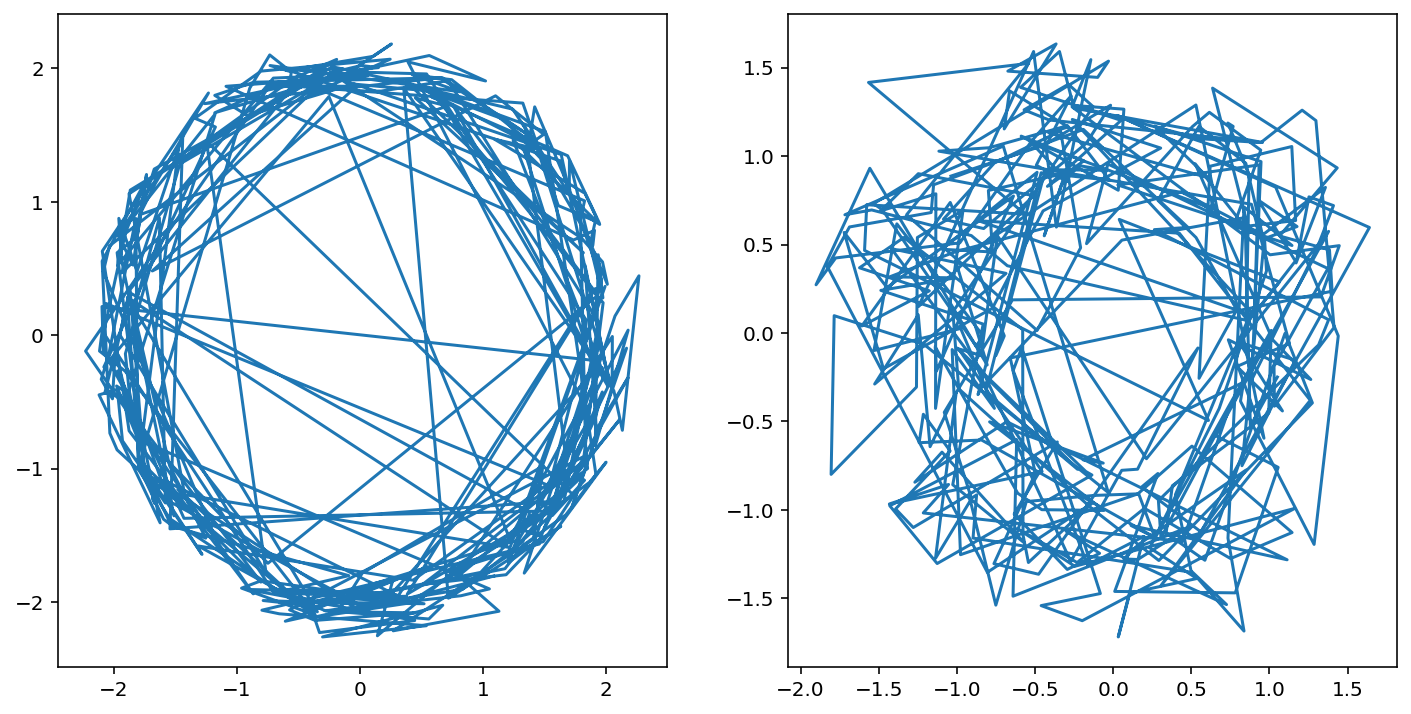

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(samples[0][0:1000,0], samples[0][0:1000,1])
ax[1].plot(latent_samples[0][0:1000,0], latent_samples[0][0:1000,1])
plt.show()